# Rahman et al. approach with c-TF-IDF

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

# Functions

In [2]:
def load_dataset(file_path):
    return pd.read_pickle(file_path)

In [3]:
def drop_nan_rows(df, column):
    df = df.dropna(subset=[column])
    df = df[df[column] != "nan"]
    df = df[df[column] != ""]
    return df

In [4]:
def create_embedding_matrix(df, column):
    embedding_matrix = np.vstack(df[column].values)
    return embedding_matrix

In [5]:
def tsne_transform(
    df, embedding_matrix, perplexity=17, max_iter=10000, random_state=42
):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=max_iter,
        random_state=random_state,
    )
    embeddings_2d = tsne.fit_transform(embedding_matrix)
    df = df.copy()
    df.loc[:, "tsne_x"] = embeddings_2d[:, 0]
    df.loc[:, "tsne_y"] = embeddings_2d[:, 1]
    return df, embeddings_2d

In [6]:
def generate_kmeans_clusters(df, embedding_matrix, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=10000, random_state=42)
    df["cluster"] = kmeans.fit_predict(embedding_matrix)
    return df

In [7]:
nltk.download("stopwords", quiet=True)

# Load Portuguese stopwords
portuguese_stopwords = stopwords.words("portuguese")
additional_stopwords = [
    "pra",
    "pro",
    "tá",
    "já",
    "ter",
    "vai",
    "vou",
    "então",
    "assim",
    "aí",
    "sobre",
    "porque",
    "como",
    "quando",
    "onde",
    "quem",
    "qual",
    "que",
    "isso",
    "isto",
    "aquilo",
    "pq"
]
portuguese_stopwords.extend(additional_stopwords)

In [8]:
def get_cluster_words(df_preprocessed, column):
    cluster_top_terms = {}
    clusters = sorted(df_preprocessed["cluster"].unique())

    # Step 1: One document per cluster
    cluster_docs = [
        " ".join(df_preprocessed[df_preprocessed["cluster"] == c][column].tolist())
        for c in clusters
    ]

    # Step 2: Compute c-TF-IDF matrix
    vectorizer = CountVectorizer(stop_words=portuguese_stopwords, min_df=3, ngram_range=(1, 2))
    X = vectorizer.fit_transform(cluster_docs)
    tf = X.multiply(1 / X.sum(axis=1))  # normalize term frequency
    idf = np.log(len(df_preprocessed) / (X > 0).sum(axis=0))  # inverse doc freq
    ctfidf_matrix = tf.multiply(idf)  # class-based TF-IDF

    ctfidf_matrix = ctfidf_matrix.tocsr()
    feature_names = vectorizer.get_feature_names_out()

    # Step 3: For each cluster, get top terms
    for idx, c in enumerate(clusters):
        row = np.asarray(ctfidf_matrix[idx].todense()).flatten()  # force 1D dense
        top_indices = row.argsort()[::-1][:20]
        top_terms = [(feature_names[i], row[i]) for i in top_indices]
        cluster_top_terms[c] = top_terms
        print(f"\nCluster {c}:")
        print([term for term, _ in top_terms])

    return cluster_top_terms

In [9]:
def get_wordcloud(cluster_top_terms):
    combined_word_freq = {}
    for c, terms in cluster_top_terms.items():
        for term, score in terms:
            if term in combined_word_freq:
                combined_word_freq[term] += score
            else:
                combined_word_freq[term] = score

    wc = WordCloud(
        width=1200, height=800, background_color="white"
    ).generate_from_frequencies(combined_word_freq)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Combined Word Cloud for All Clusters")
    plt.show()

In [10]:
def visualize_clusters(df, n_clusters=5):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x="tsne_x",
        y="tsne_y",
        hue="cluster",
        palette="tab20",
        legend=None,
        s=40,
    )
    plt.title("t-SNE visualization of clusters")
    plt.show()

In [11]:
def run_workflow(df, df_preprocessed, column, n_clusters=5):
    print(f"DF shape: {df.shape}")
    
    # Reset indices to avoid duplicate index issues
    df = df.reset_index(drop=True)
    df_preprocessed = df_preprocessed.reset_index(drop=True)
    
    embedding_matrix = create_embedding_matrix(df, f"{column}_embedding")
    df, embeddings_2d = tsne_transform(df, embedding_matrix)
    df = generate_kmeans_clusters(df, embedding_matrix, n_clusters)

    df_preprocessed = df_preprocessed.copy()
    df_preprocessed["cluster"] = df["cluster"]

    cluster_top_terms = get_cluster_words(df_preprocessed, column)
    get_wordcloud(cluster_top_terms)
    visualize_clusters(df, n_clusters)

In [12]:
def all_status_workflow(df, df_preprocessed, column, n_clusters=5):
    run_workflow(df, df_preprocessed, column, n_clusters=n_clusters)

# Define Files

In [13]:
file_path = "../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl"
column = "response"

In [14]:
df = load_dataset(file_path)
df = drop_nan_rows(df, column)
df

datetime        sex      adhd_diagnosis  age  \
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
8    2025-03-31T12:55:43+02:00   Feminino           Não tenho   19   
14   2025-03-31T13:54:40+02:00   Feminino           Não tenho   25   
15   2025-03-31T13:58:15+02:00   Feminino  Suspeito que tenho   25   
..                         ...        ...                 ...  ...   
293  2025-06-07T16:05:17+02:00   Feminino  Sim, diagnosticado   51   
296  2025-06-07T17:23:10+02:00   Feminino  Sim, diagnosticado   36   
307  2025-06-10T16:58:08+02:00   Feminino  Sim, diagnosticado   19   
308  2025-06-10T17:45:28+02:00  Masculino  Sim, diagnosticado   19   
312  2025-06-10T23:09:33+02:00   Feminino  Suspeito que tenho   20   

             education             occupation                dialect  \
1         Licenciatura              Estudante  Português de Portugal   
3             Mestrado  Trabalhador-estudante  Português de Portugal   
8         Licenciatura              Estudante  Português de Portugal   
14            Mestrado            Trabalhador  Português de Portugal   
15        Licenciatura            Trabalhador  Português de Portugal   
..                 ...                    ...                    ...   
293           Mestrado  Trabalhador-estudante  Português de Portugal   
296      Pós-Graduação              Estudante  Português de Portugal   
307  Ensino secundário  Trabalhador-estudante  Português de Portugal   
308  Ensino secundário              Estudante  Português de Portugal   
312  Ensino secundário              Estudante  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
1                    3                           3                  4  ...   
3                    2                           1                  4  ...   
8                    3                           2                  2  ...   
14                   4                           3                  4  ...   
15                   4                           2                  5  ...   
..                 ...                         ...                ...  ...   
293                  4                           2                  5  ...   
296                  5                           3                  3  ...   
307                  4                           2                  4  ...   
308                  2                           3                  4  ...   
312                  4                           2                  4  ...   

    need_fast_talk_interest need_fast_talk_information  \
1                         1                          1   
3                         1                          1   
8                         4                          4   
14                        2                          3   
15                        2                          2   
..                      ...                        ...   
293                       3                          2   
296                       2                          3   
307                       4                          4   
308                       1                          1   
312                       1                          1   

    speaking_before_thinking something_to_add something_to_add_timid  \
1                          3                4                      4   
3                          4                4                      4   
8                          2                4                      3   
14                         3                5                      4   
15                         3                5                      5   
..                       ...              ...                    ...   
293                        4                4                      5   
296                        3                4                      3   
307                        4      

## Women with ADHD vs. Others

In [15]:
mask_women_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_women_adhd

df_women_adhd = df[mask_women_adhd]
df_others = df[mask_others]

DF shape: (65, 61)

Cluster 0:
['tão', 'tudo', 'saúde', 'acho', 'mundo', 'interesses', 'sei', 'longo', 'posso', 'anos', 'diagnóstico', 'gosto', 'dizer', 'grande', 'simples', 'adoro', 'causa', 'coisas', 'etc', 'sempre']

Cluster 1:
['ainda', 'fazer', 'sei', 'tudo', 'anos', 'adoro', 'sempre', 'dizer', 'acho', 'coisas', 'gosto', 'tão', 'ver', 'grande', 'interesses', 'ajuda', 'causa', 'facto', 'problemas', 'forma']

Cluster 2:
['fazer', 'gosto', 'ver', 'sociedade', 'simples', 'tão', 'tudo', 'saúde', 'realidade', 'problemas', 'posso', 'mundo', 'maior', 'sempre', 'sei', 'interesses', 'longo', 'grande', 'forma', 'facto']

Cluster 3:
['tudo', 'sempre', 'ver', 'tão', 'sei', 'mundo', 'posso', 'anos', 'ainda', 'problemas', 'sociedade', 'longo', 'maior', 'realidade', 'saúde', 'acho', 'interesses', 'fazer', 'forma', 'diagnóstico']

Cluster 4:
['ver', 'sociedade', 'problemas', 'adoro', 'ainda', 'etc', 'forma', 'grande', 'facto', 'devia', 'coisas', 'maior', 'realidade', 'saúde', 'simples', 'ajuda', '

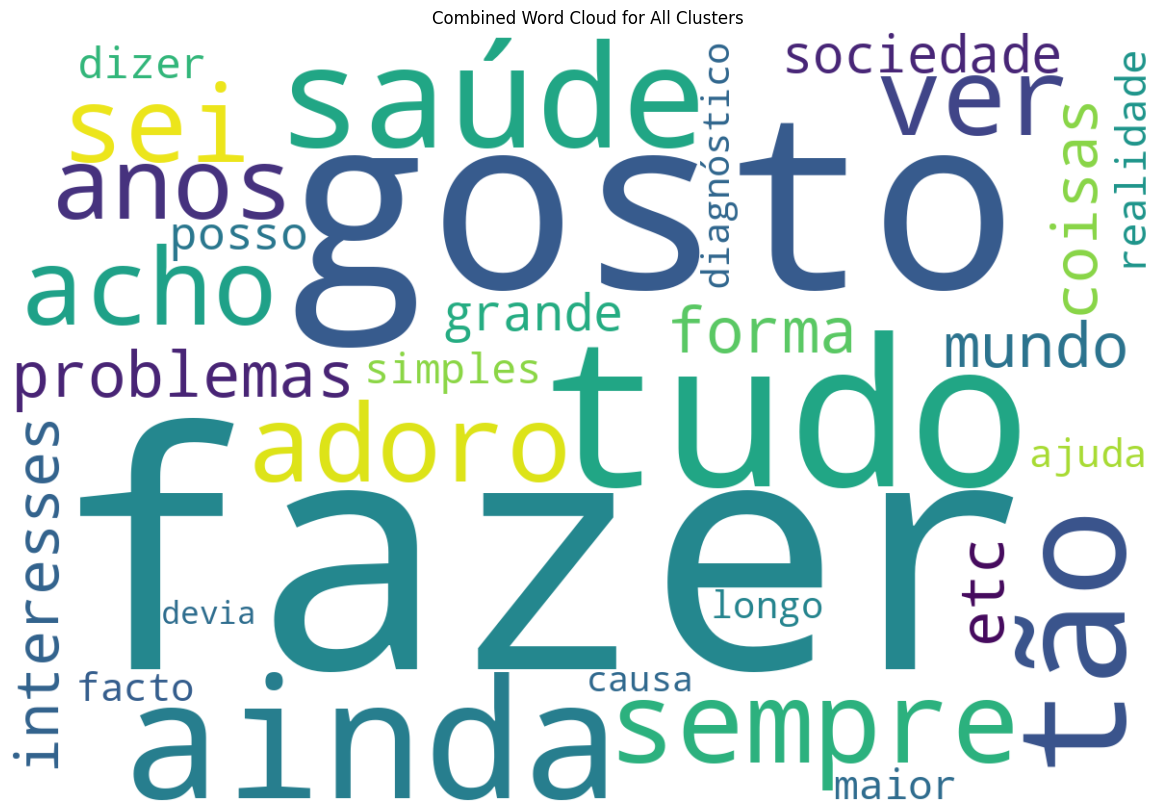

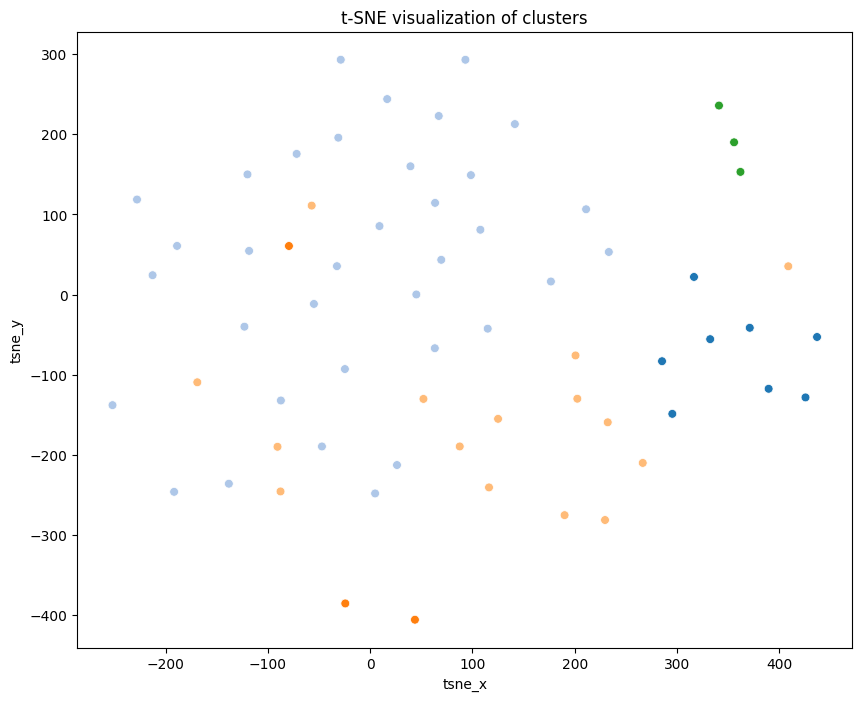

In [16]:
all_status_workflow(df_women_adhd, df_women_adhd, column, n_clusters=5)

DF shape: (382, 61)

Cluster 0:
['anos', 'memória', 'sempre', 'fazer', 'pai', 'mim', 'pessoas', 'lembro', 'dia', 'algo', 'hoje', 'nunca', 'altura', 'vezes', 'tudo', 'ainda', 'vez', 'disse', 'sinto', 'mãe']

Cluster 1:
['dia', 'fazer', 'hoje', 'trabalho', 'tempo', 'ir', 'tarde', 'casa', 'trabalhar', 'bem', 'acordei', 'ainda', 'senti', 'coisas', 'pouco', 'melhor', 'fiz', 'consegui', 'horas', 'sempre']

Cluster 2:
['dia', 'algo', 'escrever', 'sinto', 'fazer', 'sempre', 'vezes', 'hoje', 'tudo', 'responder', 'sei', 'mim', 'pensar', 'algum', 'vida', 'momento', 'ainda', 'pessoas', 'tipo', 'diário']

Cluster 3:
['gosto', 'música', 'fazer', 'algo', 'dia', 'coisas', 'adoro', 'interesse', 'vida', 'forma', 'pessoas', 'ver', 'sentir', 'sempre', 'ler', 'sinto', 'bem', 'bastante', 'ouvir', 'vezes']

Cluster 4:
['dia', 'pessoas', 'ver', 'fez', 'interesse', 'tão', 'forma', 'casa', 'apesar', 'dia dia', 'voltar', 'realmente', 'campo', 'mundo', 'interessante', 'jogo', 'tal', 'etc', 'cada', 'outras']


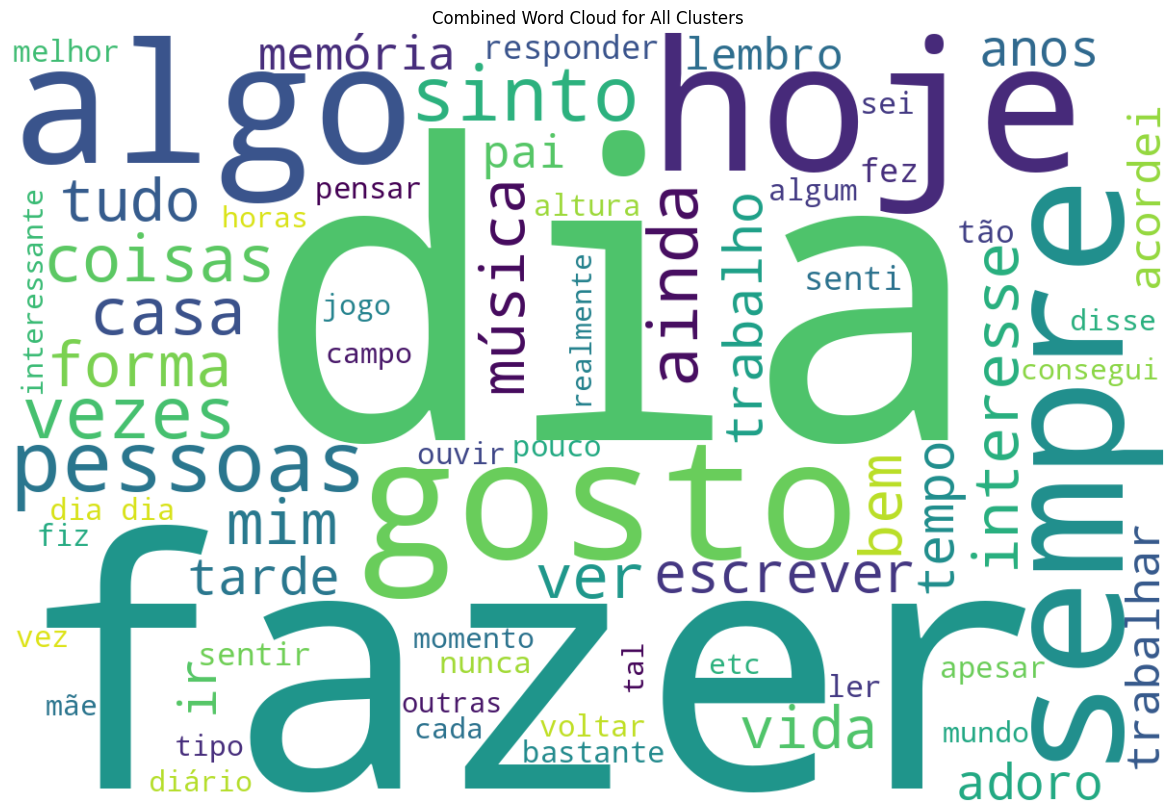

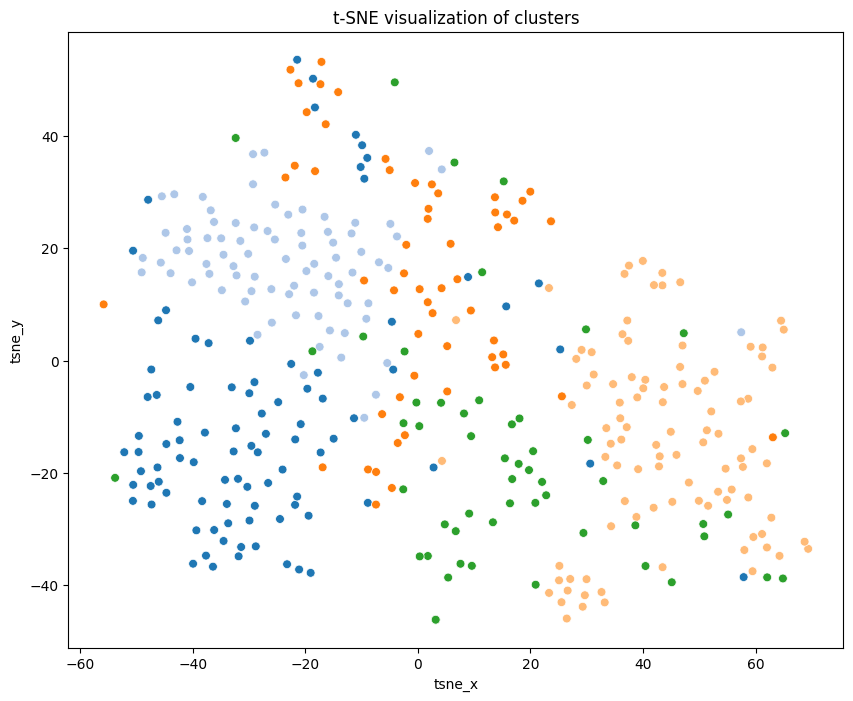

In [17]:
all_status_workflow(df_others, df_others, column, n_clusters=5)

## ADHD vs. Non-ADHD

In [18]:
mask_adhd = (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_adhd

df_adhd = df[mask_adhd]
df_others = df[mask_others]

DF shape: (94, 61)

Cluster 0:
['tudo', 'gosto', 'sempre', 'dia', 'tão', 'mundo', 'coisas', 'adoro', 'tipo', 'desde', 'própria', 'qualquer', 'saúde', 'bem', 'apenas', 'acho', 'nada', 'tempo', 'vida', 'grande']

Cluster 1:
['hoje', 'trabalho', 'dia', 'ainda', 'casa', 'fazer', 'bem', 'uns', 'nada', 'nunca', 'consegui', 'menos', 'melhor', 'vida', 'gostava', 'memória', 'cansada', 'tempo', 'ninguém', 'pessoas']

Cluster 2:
['consigo', 'fazer', 'gosto', 'tudo', 'tentar', 'conseguir', 'algum', 'nada', 'cabeça', 'pessoas', 'sei', 'vezes', 'vez', 'sinto', 'outras', 'montes', 'mundo', 'rápido', 'perder', 'pensar']

Cluster 3:
['pessoas', 'vida', 'mim', 'dia', 'comigo', 'anos', 'ainda', 'acho', 'nunca', 'sempre', 'uns', 'pessoa', 'bem', 'tudo', 'sei', 'muitas', 'nesse', 'todos', 'falta', 'sinto']

Cluster 4:
['phda', 'pessoas', 'vida', 'ver', 'lá', 'adoro', 'ainda', 'sei', 'tudo', 'algo', 'problemas', 'tipo', 'sociedade', 'sim', 'mesma', 'ajuda', 'consegui', 'bem', 'anos', 'tanto']


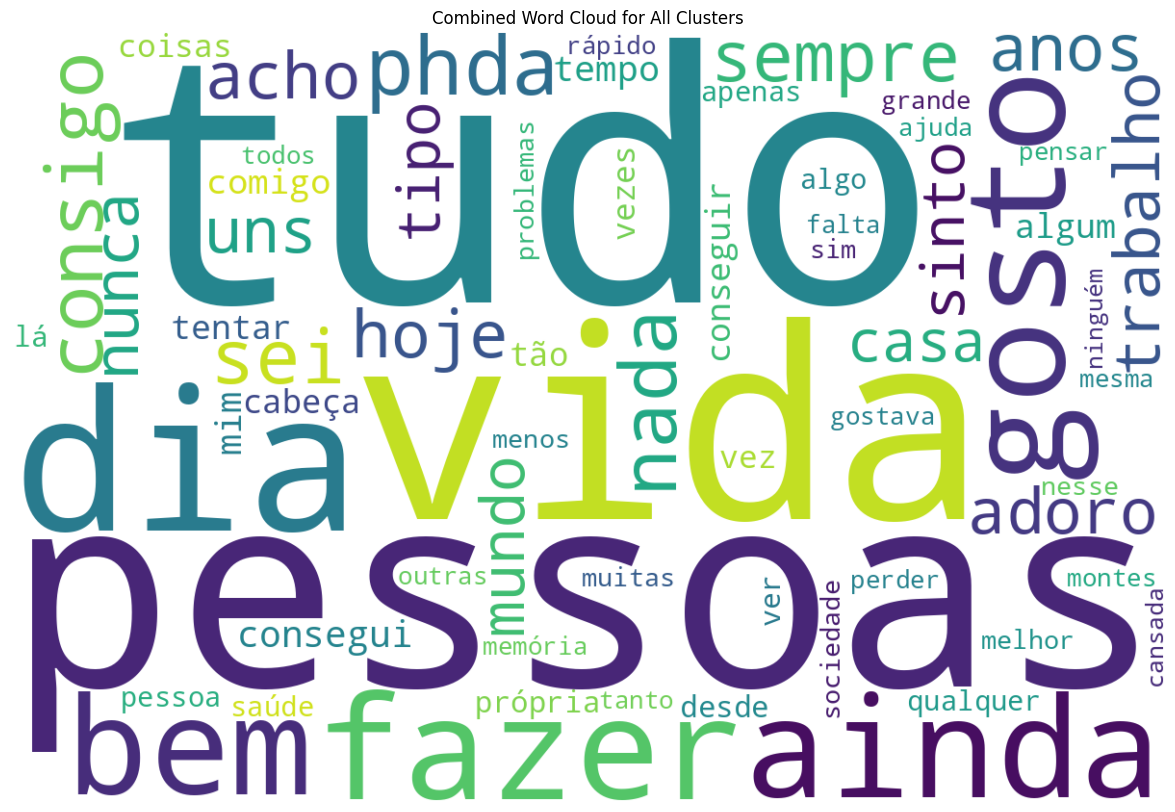

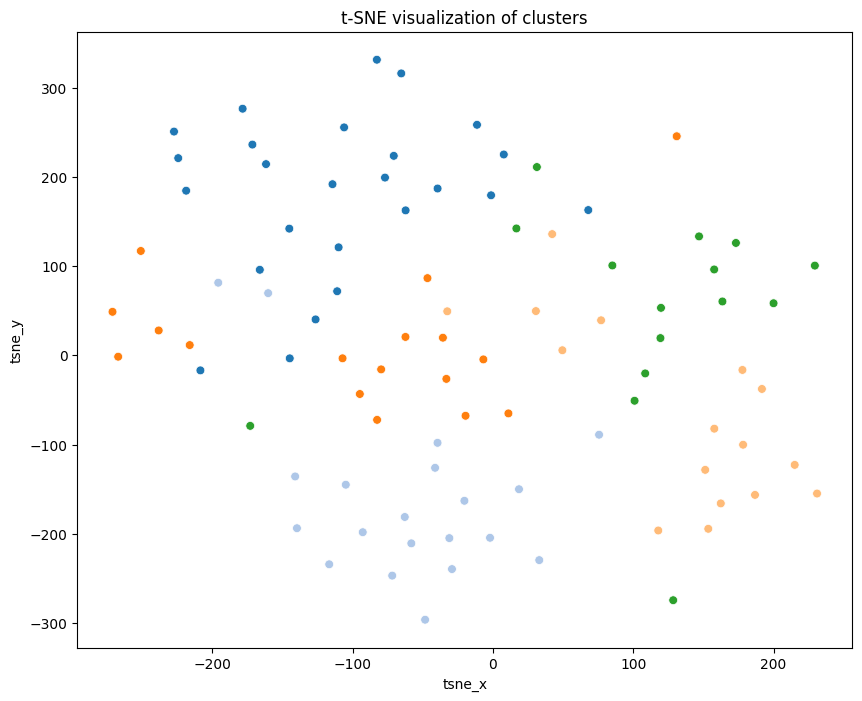

In [19]:
all_status_workflow(df_adhd, df_adhd, column)

DF shape: (353, 61)

Cluster 0:
['interesse', 'dia', 'ver', 'forma', 'gosto', 'jogo', 'animais', 'interesse especial', 'especial', 'fez', 'algo', 'mundo', 'casa', 'acho', 'parte', 'têm', 'voltar', 'ainda', 'tão', 'pessoas']

Cluster 1:
['pessoas', 'fazer', 'algo', 'escrever', 'dia', 'sinto', 'vezes', 'sempre', 'tudo', 'medo', 'mim', 'vida', 'pensar', 'sei', 'coisas', 'memória', 'vez', 'pessoa', 'momento', 'hoje']

Cluster 2:
['gosto', 'música', 'dia', 'fazer', 'adoro', 'coisas', 'algo', 'vida', 'forma', 'pessoas', 'sentir', 'ler', 'sinto', 'bem', 'ouvir', 'interesse', 'sempre', 'ver', 'posso', 'desporto']

Cluster 3:
['anos', 'pai', 'sempre', 'fazer', 'memória', 'dia', 'hoje', 'algo', 'mim', 'lembro', 'altura', 'nunca', 'tudo', 'ainda', 'disse', 'mãe', 'vez', 'vezes', 'comigo', 'ir']

Cluster 4:
['dia', 'fazer', 'hoje', 'tempo', 'trabalho', 'ir', 'tarde', 'casa', 'bem', 'ainda', 'trabalhar', 'senti', 'coisas', 'melhor', 'fiz', 'pouco', 'sempre', 'ver', 'consegui', 'quero']


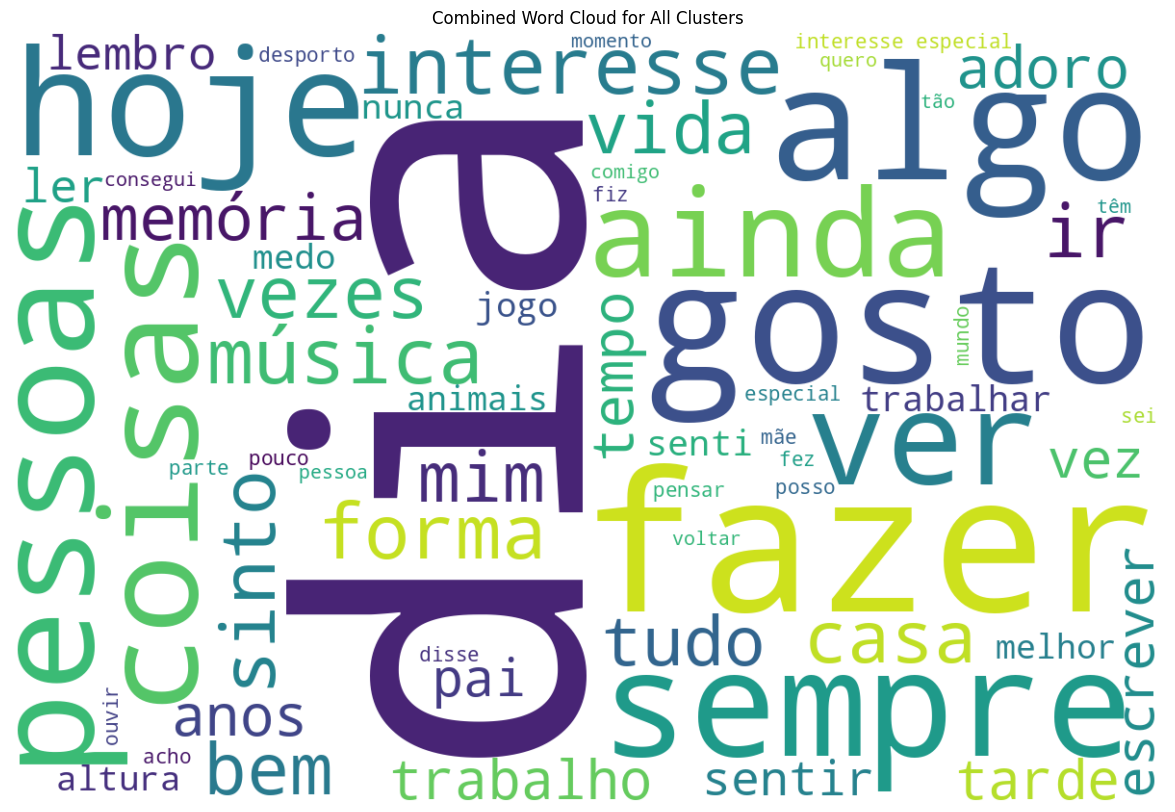

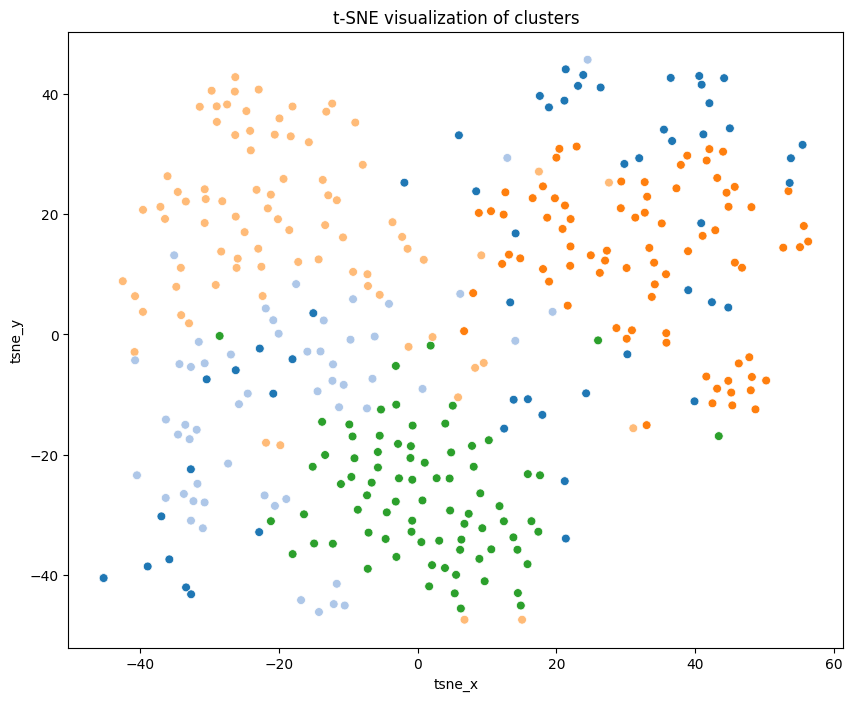

In [20]:
all_status_workflow(df_others, df_others, column)

## Women with ADHD vs. Men with ADHD

In [21]:
mask_women_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = (df['sex']=="Masculino") & (df['adhd_diagnosis']=="Sim, diagnosticado")

df_women_adhd = df[mask_women_adhd]
df_men_adhd = df[mask_others]

DF shape: (65, 61)

Cluster 0:
['tão', 'tudo', 'saúde', 'acho', 'mundo', 'interesses', 'sei', 'longo', 'posso', 'anos', 'diagnóstico', 'gosto', 'dizer', 'grande', 'simples', 'adoro', 'causa', 'coisas', 'etc', 'sempre']

Cluster 1:
['ainda', 'fazer', 'sei', 'tudo', 'anos', 'adoro', 'sempre', 'dizer', 'acho', 'coisas', 'gosto', 'tão', 'ver', 'grande', 'interesses', 'ajuda', 'causa', 'facto', 'problemas', 'forma']

Cluster 2:
['fazer', 'gosto', 'ver', 'sociedade', 'simples', 'tão', 'tudo', 'saúde', 'realidade', 'problemas', 'posso', 'mundo', 'maior', 'sempre', 'sei', 'interesses', 'longo', 'grande', 'forma', 'facto']

Cluster 3:
['tudo', 'sempre', 'ver', 'tão', 'sei', 'mundo', 'posso', 'anos', 'ainda', 'problemas', 'sociedade', 'longo', 'maior', 'realidade', 'saúde', 'acho', 'interesses', 'fazer', 'forma', 'diagnóstico']

Cluster 4:
['ver', 'sociedade', 'problemas', 'adoro', 'ainda', 'etc', 'forma', 'grande', 'facto', 'devia', 'coisas', 'maior', 'realidade', 'saúde', 'simples', 'ajuda', '

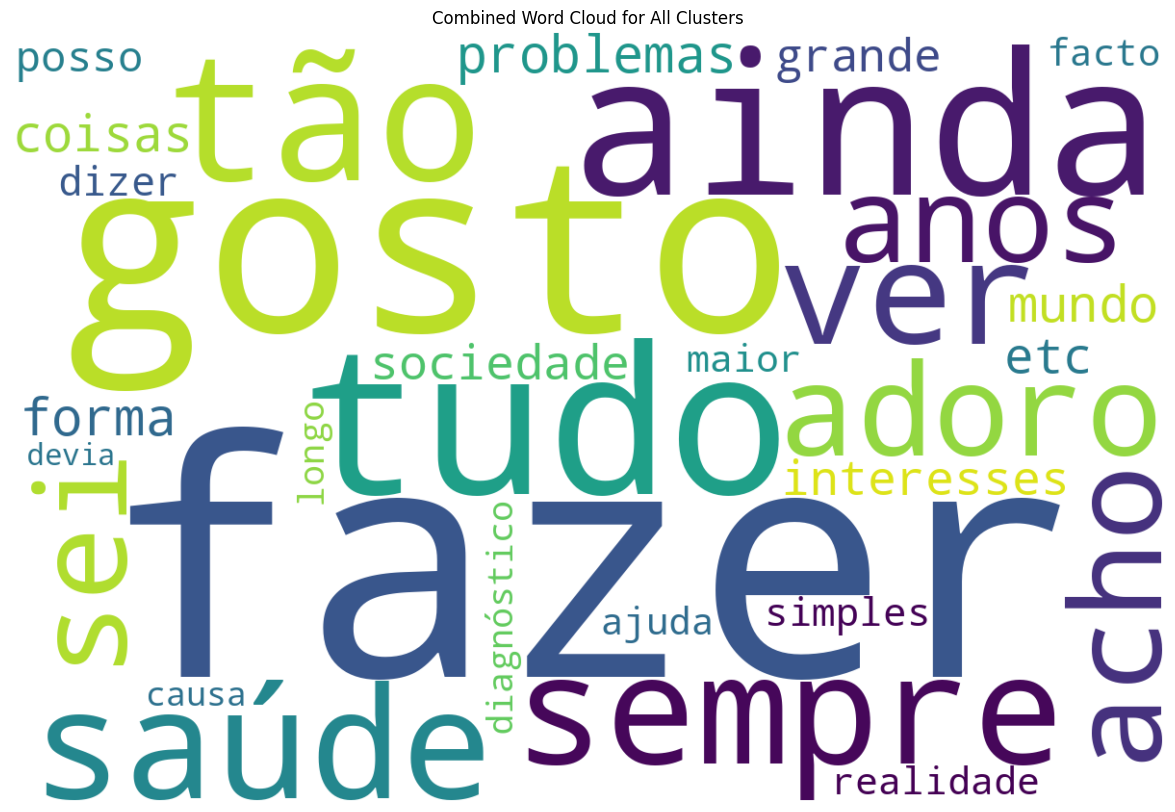

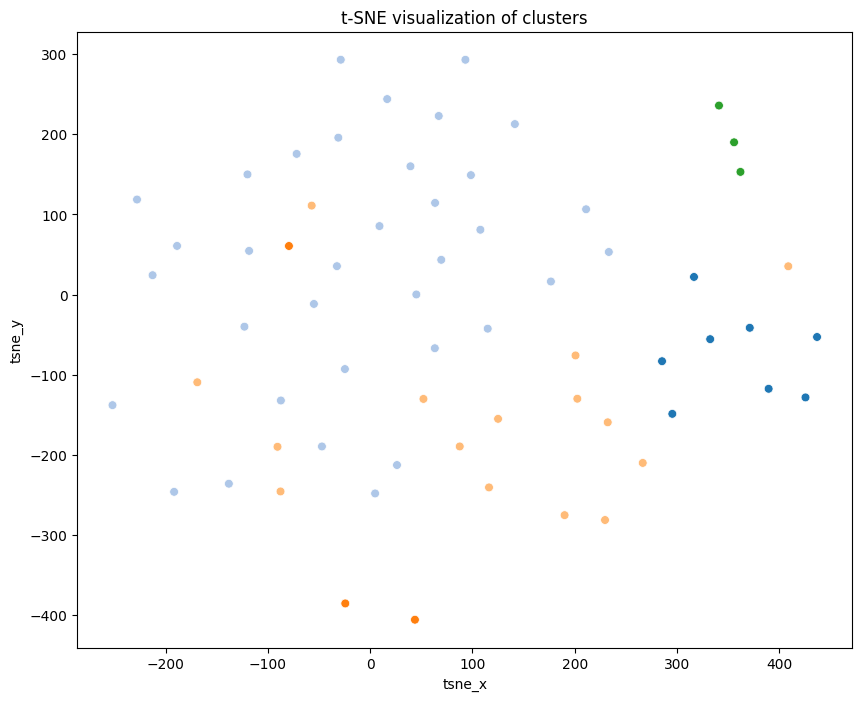

In [22]:
all_status_workflow(df_women_adhd, df_women_adhd, column)

DF shape: (29, 61)

Cluster 0:
['apenas', 'qualquer', 'estudo', 'outro', 'trabalho', 'coisas', 'pessoa', 'tão', 'bastante', 'gosto', 'vida', 'sempre', 'sei', 'tipo', 'vezes', 'volta', 'tanto', 'muitas', 'fazer', 'fez']

Cluster 1:
['muitas', 'vida', 'sei', 'tanto', 'dia', 'bastante', 'fez', 'outro', 'pessoas', 'vezes', 'tipo', 'qualquer', 'estudo', 'anos', 'sempre', 'trabalho', 'tão', 'volta', 'fazer', 'gosto']

Cluster 2:
['dia', 'pessoas', 'algo', 'fazer', 'sempre', 'gosto', 'trabalho', 'tão', 'bem', 'vezes', 'consegui', 'tipo', 'vida', 'volta', 'coisas', 'apenas', 'sei', 'pessoa', 'anos', 'estudo']

Cluster 3:
['sempre', 'gosto', 'fez', 'algo', 'vezes', 'qualquer', 'tipo', 'sei', 'tanto', 'volta', 'consegui', 'bem', 'fazer', 'muitas', 'anos', 'vida', 'tão', 'trabalho', 'estudo', 'pessoas']

Cluster 4:
['trabalho', 'dia', 'anos', 'pessoas', 'outro', 'consegui', 'qualquer', 'vida', 'tanto', 'volta', 'bem', 'bastante', 'fazer', 'sempre', 'tão', 'fez', 'pessoa', 'muitas', 'apenas', 'alg

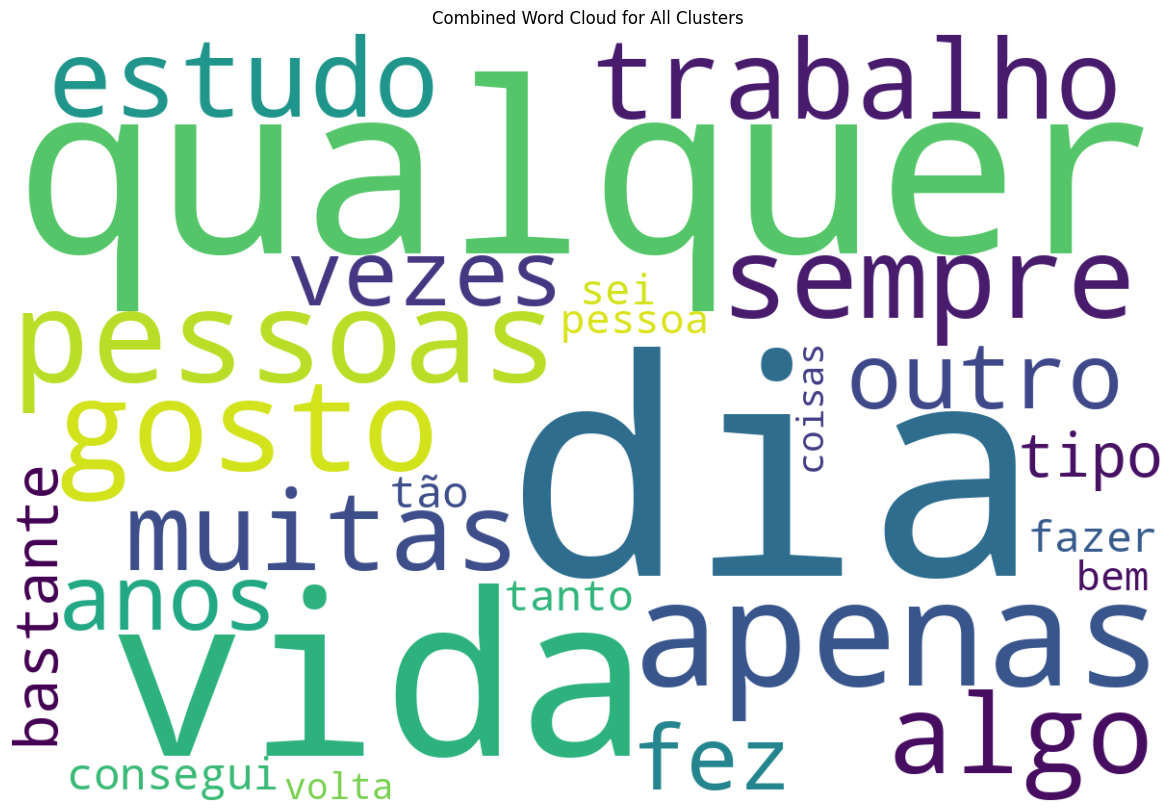

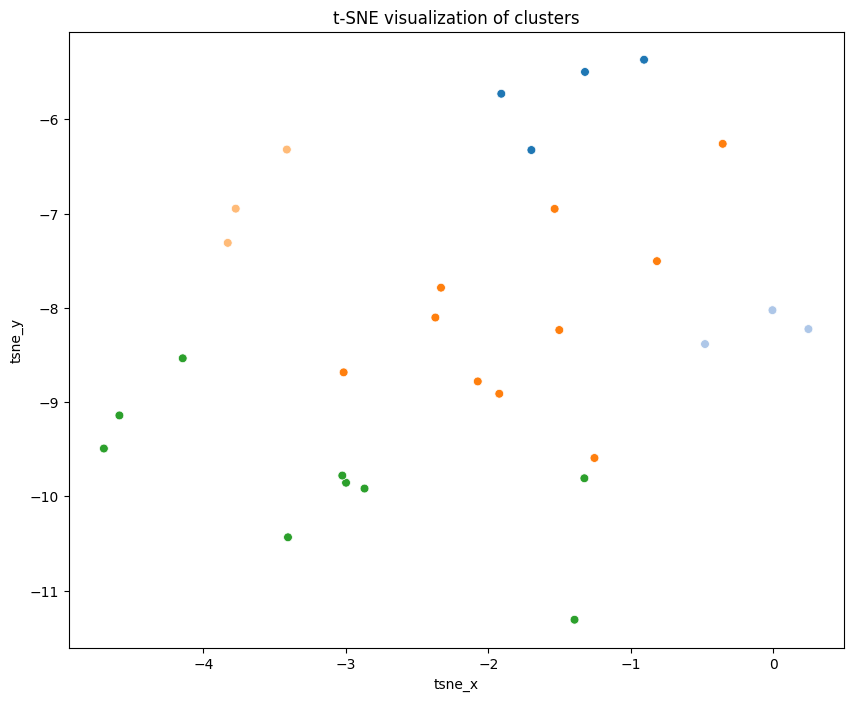

In [23]:
all_status_workflow(df_men_adhd, df_men_adhd, column)

## Women vs. Men

In [24]:
mask_women = (df['sex']=="Feminino")
mask_others = ~mask_women

df_women = df[mask_women]
df_others = df[mask_others]

DF shape: (285, 61)

Cluster 0:
['dia', 'fazer', 'hoje', 'trabalho', 'casa', 'ainda', 'bem', 'tempo', 'tarde', 'ir', 'manhã', 'trabalhar', 'coisas', 'sinto', 'semana', 'fiquei', 'dias', 'quero', 'hoje dia', 'menos']

Cluster 1:
['gosto', 'música', 'coisas', 'dia', 'fazer', 'adoro', 'pessoas', 'vida', 'interesse', 'ler', 'sempre', 'bem', 'forma', 'acho', 'mundo', 'tempo', 'posso', 'algo', 'sinto', 'tudo']

Cluster 2:
['fazer', 'prefiro', 'sei', 'escrever', 'consigo', 'hoje', 'nunca', 'dia', 'vezes', 'capaz', 'pergunta', 'diário', 'comprar', 'embora', 'vontade', 'situação', 'muita', 'pensar', 'tão', 'vida']

Cluster 3:
['sempre', 'mim', 'pessoas', 'fazer', 'anos', 'nunca', 'tudo', 'memória', 'pai', 'dia', 'comigo', 'algo', 'vezes', 'hoje', 'ainda', 'vida', 'mãe', 'falar', 'lembro', 'sinto']

Cluster 4:
['pessoas', 'ver', 'dia', 'interesse', 'casa', 'forma', 'cada', 'voltar', 'ainda', 'etc', 'homem', 'saúde', 'lá', 'anos', 'coisas', 'gosto', 'phda', 'vez', 'história', 'acho']


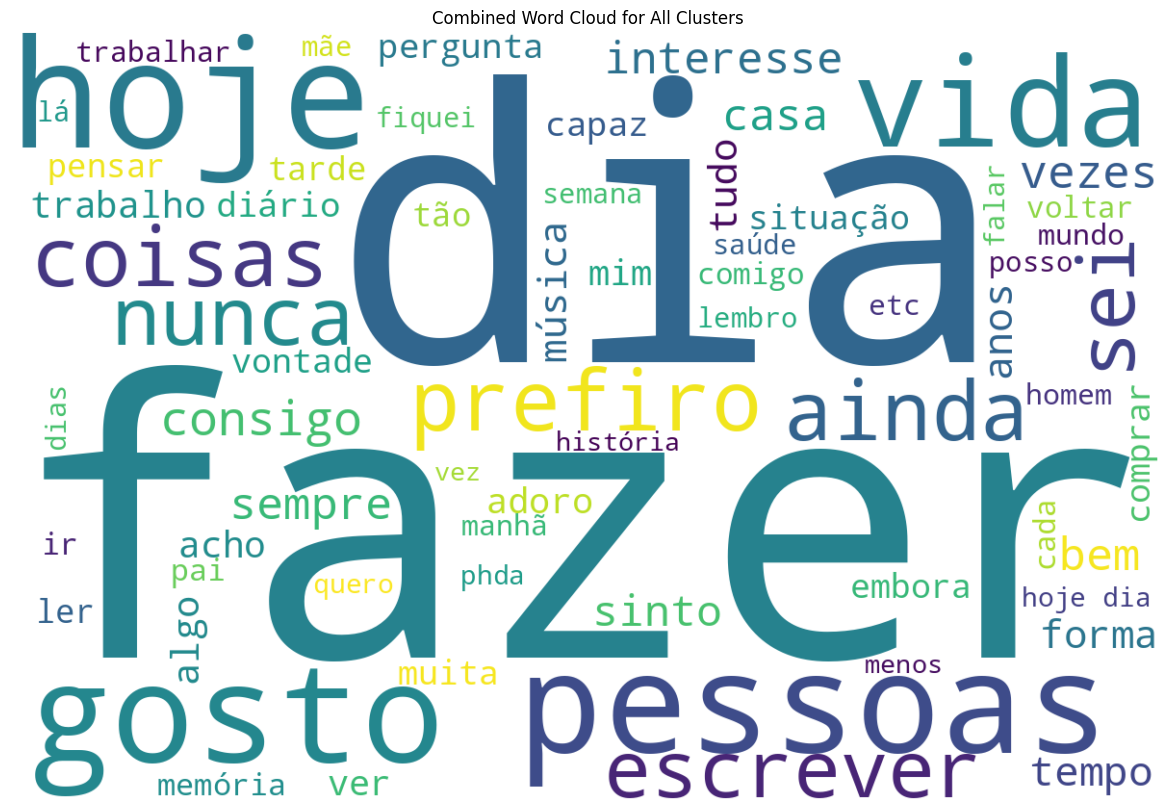

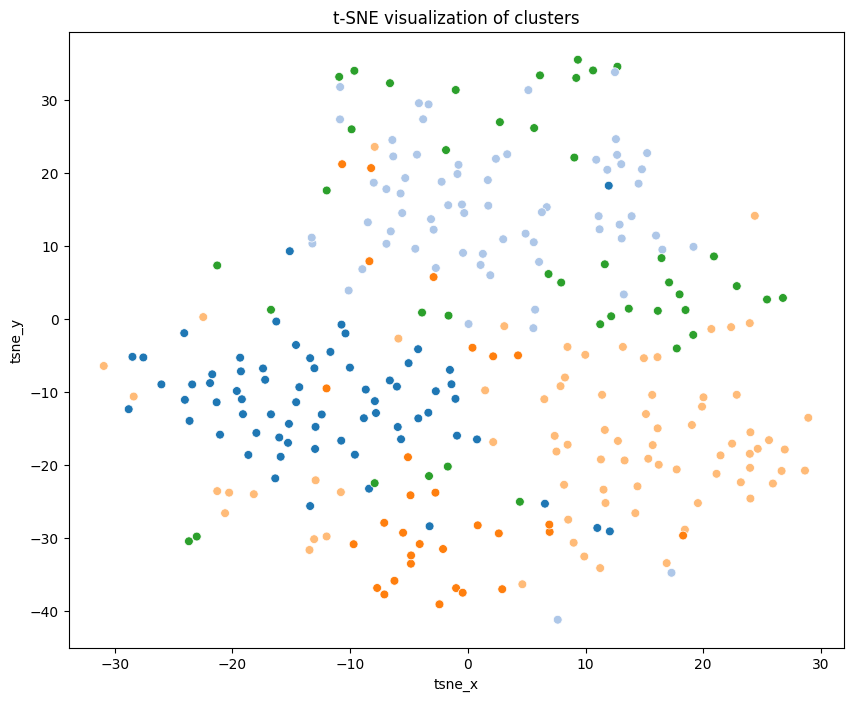

In [25]:
all_status_workflow(df_women, df_women, column)

DF shape: (162, 61)

Cluster 0:
['gosto', 'jogar', 'jogo', 'sempre', 'jogos', 'algo', 'fazer', 'desde', 'música', 'dia', 'ver', 'tipo', 'sentir', 'parte', 'história', 'sinto', 'qualquer', 'coisas', 'bastante', 'vezes']

Cluster 1:
['dia', 'fazer', 'ir', 'hoje', 'tempo', 'senti', 'trabalho', 'fiz', 'melhor', 'algo', 'coisas', 'durante', 'amigos', 'apesar', 'bem', 'consegui', 'ainda', 'nada', 'fiquei', 'semana']

Cluster 2:
['anos', 'memória', 'hoje', 'dia', 'algo', 'vez', 'altura', 'mim', 'vida', 'amigos', 'pessoa', 'pessoas', 'sempre', 'ainda', 'apesar', 'fazer', 'cabeça', 'vezes', 'pensar', 'qualquer']

Cluster 3:
['algo', 'dia', 'sinto', 'tudo', 'vezes', 'pessoas', 'saber', 'vida', 'momento', 'bastante', 'sempre', 'situações', 'gosto', 'confortável', 'coisas', 'sei', 'cabeça', 'fazer', 'apesar', 'algum']

Cluster 4:
['jogo', 'dia', 'usar', 'contra', 'qualquer', 'forma', 'humana', 'equipa', 'mente', 'data', 'realmente', 'carros', 'história', 'mexer', 'outro', 'semana', 'ver', 'toda', 

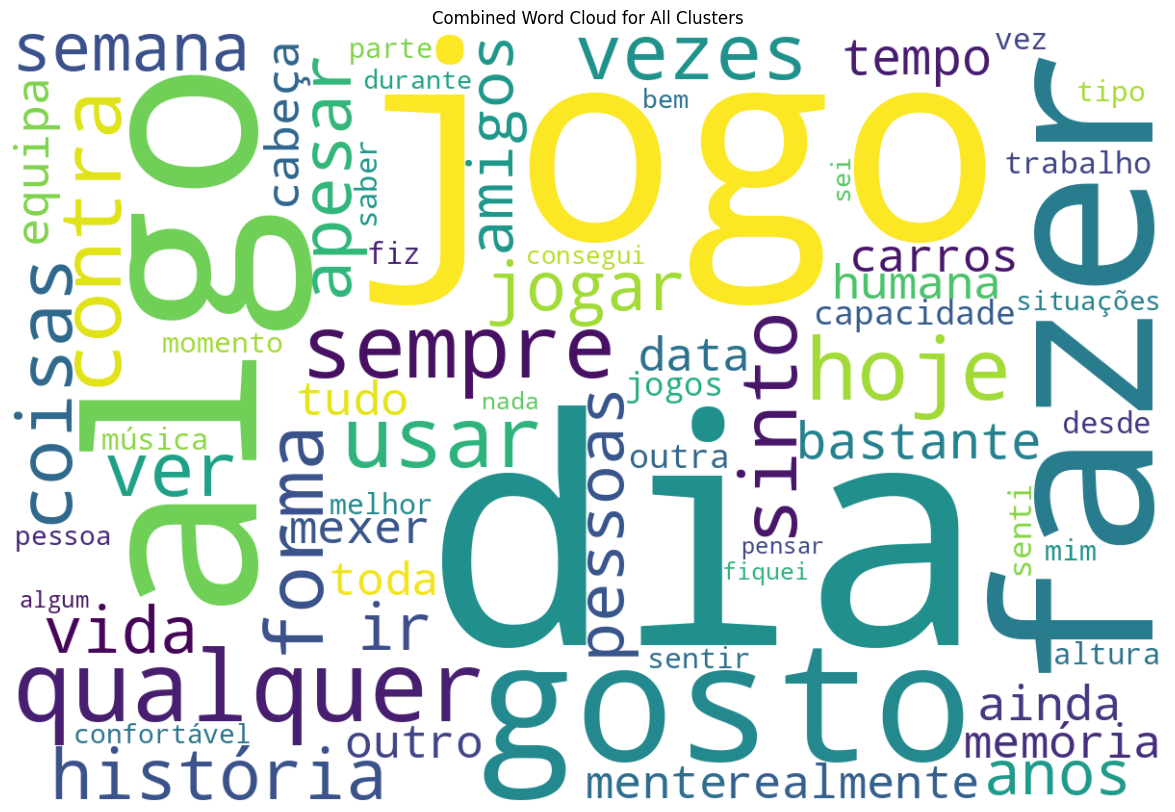

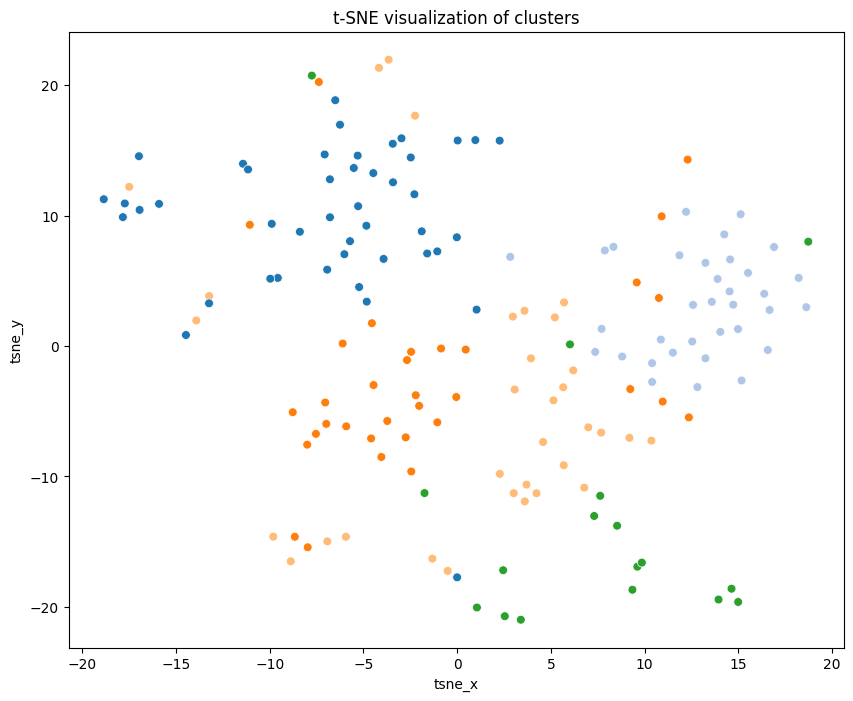

In [26]:
all_status_workflow(df_others, df_others, column)